In [1]:
%matplotlib inline

In [2]:
import os
import json

import numpy as np
import pandas as pd
import spacy
import nltk
from nltk import FreqDist
import pyLDAvis
import pyLDAvis.gensim
import gensim
from gensim import corpora
import gender_guesser.detector as gender
import seaborn as sns
import matplotlib.pyplot as plt

from utils import load_results_json

pd.set_option("display.max_colwidth", 200)

C:\Users\dbarker3\myAnaconda\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Load Data

In [3]:
SURVEY_DATA = 'data/survey_responses.json'

with open(SURVEY_DATA, 'r') as infile:
    data = json.load(infile)

In [4]:
SURVEY_KEY = {
    "1580501121695": "age",
    "1580502021669": "gender",
    "1580501179775": "wine_consumption", 
    "1580501278669": "purchase_loc",
    "1580501455874": "decision_free_txt",
    "1580501539737": "inform_sentiment",
    "1580501784999": "apps_used",
    "1580502106106": "app_freq",
    "1580502188366": "app_loc",
    "1580502228879": "app_changes"
}

In [5]:
s_list = []
for row in data:
    qid = row['id']
    skey = SURVEY_KEY[qid]
    s = pd.Series([a for a in row['answers']], name=skey)
    s_list.append(s)
    # print(skey, row)
    # print(len(row['answers']))
    
df = pd.concat(s_list, axis=1)


# Create purchase loc columns
PLOC_KEY = {
    'Supermarket': 'ploc_supermarket',
    'Retail Bottle Shop': 'ploc_retail_shop',
    'Restaurant': 'ploc_restaurant',
    'Convenience Store': 'ploc_conv_store',
    'Winery': 'ploc_winery',
    'Other': 'ploc_other',    
}

df_ploc = df['purchase_loc'].str.get_dummies(';')
new_column_names = {}
for orig_name in df_ploc.columns:
    new_name = PLOC_KEY[orig_name]
    new_column_names[orig_name] = new_name
# print(new_column_names)
df = pd.concat([df, df_ploc], axis=1)
df = df.rename(columns=new_column_names)


# Create app used column
USED_KEY = {
    'Delectable': 'used_delectable',
    'Wine.com': 'used_wine_com',
    'Wine Ring': 'used_wine_ring',
    'Wine-Searcher': 'used_wine_searcher',
    'Vivino': 'used_vivino',
    'Other': 'used_other',  
    'I have not used a wine recommendation app': 'used_never'
}

df_used = df['apps_used'].str.get_dummies(';')
new_column_names = {}
for orig_name in df_used.columns:
    new_name = USED_KEY[orig_name]
    new_column_names[orig_name] = new_name
# print(new_column_names)
df = pd.concat([df, df_used], axis=1)
df = df.rename(columns=new_column_names)


del df['purchase_loc']
del df['apps_used']
display(df)
# display(df.head())
# display(df.tail())

,age,gender,wine_consumption,decision_free_txt,inform_sentiment,app_freq,app_loc,app_changes,ploc_conv_store,ploc_other,ploc_restaurant,ploc_retail_shop,ploc_supermarket,ploc_winery,used_delectable,used_never,used_vivino,used_wine_searcher,used_wine_com
0,30 - 39,Male,0,I have some preferred brand,5,1,In store,Not sure now,0,0,0,0,1,1,0,1,0,0,0
1,30 - 39,Male,1-2,meal being paired with.,4,3,At the store.,location integration,0,0,0,1,0,0,1,0,1,0,1
2,18 - 29,Male,1-2,taste,4,1,n/a,n/a,0,0,0,1,1,0,0,1,0,0,0
3,18 - 29,Male,1-2,Past experience with wines I have had,4,3,At home on my phone,Make it easier to find similar wines to me preferred choices,0,0,0,1,0,1,0,0,1,0,1
4,30 - 39,Female,0,I do it based on recommendations from my friends,4,1,I'd most likely use it on my mobile phone because I may be looking up recommendations from the convenience store while shopping for friends and family.,I'd like it to its popularity star ratings / connoisseur inputs,1,0,0,0,0,0,0,1,0,0,0
5,18 - 29,Male,3-4,Price... I love Stella Rose because it's cheap and delicious,4,2,At home or at a social gathering when I'm trying to find new wines to try.,Filter out better rated wines,0,0,0,1,1,1,0,0,1,0,0
6,18 - 29,Male,1-2,cheap but looks fancy,1,1,I don't,i dont,1,0,0,0,0,0,0,1,0,0,0
7,30 - 39,Male,1-2,Check label and then check rating for that wine and year,2,1,Not using yet but would like to use it,Not using yet but would like to use it,0,0,0,1,1,0,0,1,0,0,0
8,18 - 29,Male,1-2,"price, and bottle location/origin",4,2,at the store,recommended bottles based on food pairings,1,0,0,1,1,1,0,0,1,0,0
9,30 - 39,Male,0,Which one has a bird on it. Or if it's from a town I like.,2,1,N/A,N/A,0,0,0,0,1,0,0,1,0,0,0


### Data preprocessing

In [6]:
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dbarker3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# stop_words = stopwords.words('english')
stop_words = STOP_WORDS


def remove_stopwords(x):
    """ Remove common stopwords from the review text. """
    txt = " ".join([t for t in x if t not in stop_words])
    return txt


def remove_short_words(x, min_length=2):
    """ Remove words with less than certain length. """
    word = ' '.join([w for w in x.split() if len(w) >= min_length])
    return word

```App``` and ```Wine``` are common words appearing the review (obviously), but not terribly informative. We'll add these to our stopwords.

In [18]:
stop_words.add('app')
stop_words.add('apps')
stop_words.add('wine')
stop_words.add('wines')
stop_words.add('vivino')

In [19]:
len(stop_words)

331

In [20]:
df['clean_decision_text'] = df['decision_free_txt'].str.replace("[^a-zA-Z#]", " ")
clean_decision1 = df['clean_decision_text'].apply(remove_short_words)
clean_decision2 = [r.lower() for r in clean_decision1]
clean_decision3 = [remove_stopwords(r.split()) for r in clean_decision2]
# clean_reviews3 = [r.lower() for r in clean_reviews2]
df['clean_decision_text'] = clean_decision3
display(df.head())
display(df.tail())

,age,gender,wine_consumption,decision_free_txt,inform_sentiment,app_freq,app_loc,app_changes,ploc_conv_store,ploc_other,ploc_restaurant,ploc_retail_shop,ploc_supermarket,ploc_winery,used_delectable,used_never,used_vivino,used_wine_searcher,used_wine_com,clean_decision_text
0,30 - 39,Male,0,I have some preferred brand,5,1,In store,Not sure now,0,0,0,0,1,1,0,1,0,0,0,preferred brand
1,30 - 39,Male,1-2,meal being paired with.,4,3,At the store.,location integration,0,0,0,1,0,0,1,0,1,0,1,meal paired
2,18 - 29,Male,1-2,taste,4,1,n/a,n/a,0,0,0,1,1,0,0,1,0,0,0,taste
3,18 - 29,Male,1-2,Past experience with wines I have had,4,3,At home on my phone,Make it easier to find similar wines to me preferred choices,0,0,0,1,0,1,0,0,1,0,1,past experience
4,30 - 39,Female,0,I do it based on recommendations from my friends,4,1,I'd most likely use it on my mobile phone because I may be looking up recommendations from the convenience store while shopping for friends and family.,I'd like it to its popularity star ratings / connoisseur inputs,1,0,0,0,0,0,0,1,0,0,0,based recommendations friends


,age,gender,wine_consumption,decision_free_txt,inform_sentiment,app_freq,app_loc,app_changes,ploc_conv_store,ploc_other,ploc_restaurant,ploc_retail_shop,ploc_supermarket,ploc_winery,used_delectable,used_never,used_vivino,used_wine_searcher,used_wine_com,clean_decision_text
14,18 - 29,Female,1-2,Price / packaging,2,2,At wine shops,Better recommendation systems - tell me what to drink and WHY,0,0,1,0,1,1,0,0,1,0,0,price packaging
15,30 - 39,Female,0,I dont buy,3,1,NA,NA,0,1,0,0,0,0,0,1,0,0,0,dont buy
16,30 - 39,Male,1-2,red wine,4,1,i never used,i never used,0,0,1,0,1,0,0,1,0,0,0,red
17,18 - 29,Male,1-2,Outlooking,2,2,At market or Store,Recommendation based on my social media post,0,0,0,1,1,0,0,0,1,1,0,outlooking
18,40 - 49,Male,1-2,NA,3,3,NA,NA,0,0,1,0,0,0,0,0,0,1,0,na


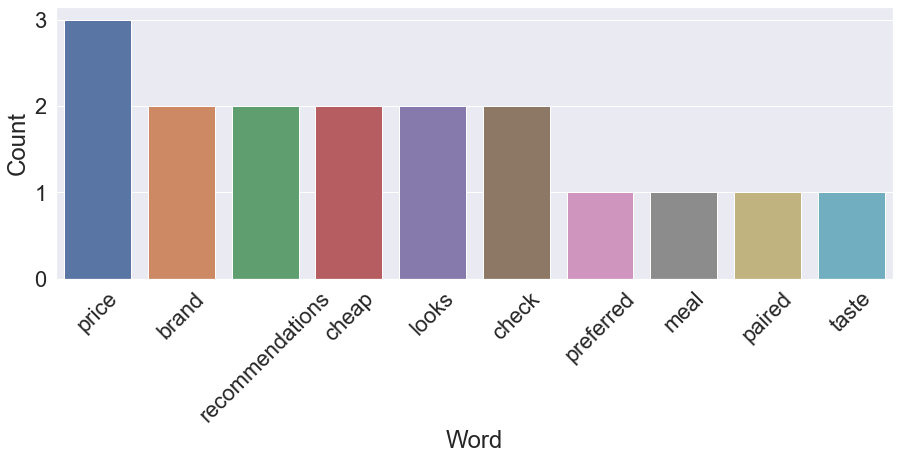

In [86]:
def most_freq_words(x, terms=25):
    """ Plot the most frequent review terms. """
    sns.set(font_scale=2)
    
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    df_words = pd.DataFrame({'word': list(fdist.keys()), 'count': list(fdist.values())})
    
    d = df_words.nlargest(columns='count', n=terms)
    # display(d)
    
    fig, ax = plt.subplots(figsize=(15,5))
    sns.barplot(x='word', y='count', data=d, ax=ax)
    ax.set_ylabel('Count')
    plt.xticks(rotation=45)
    ax.set_xlabel('Word')
    
    plt.show()
    plt.close()
    
    
# most_freq_words(df['decision_free_txt'], 50)
most_freq_words(df['clean_decision_text'], 10)

### Perform NLP

In [87]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


def lemmatization(texts, tags=['NOUN', 'ADJ', 'VERB']):
    """ Create lemmas from our product review text. """
    output = []
    for review in texts:
        doc = nlp(" ".join(review))
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [88]:
tokenized_reviews = pd.Series(df['clean_decision_text']).apply(lambda x: x.split())
print(tokenized_reviews[0])

review_lemmas = lemmatization(tokenized_reviews, tags=['NOUN', 'ADJ', 'VERB'])
# review_lemmas = lemmatization(tokenized_reviews, tags=['NOUN', 'VERB'])
print(review_lemmas[0])

['preferred', 'brand']
['preferred', 'brand']


In [89]:
review_lemmas2 = []
for i in range(len(review_lemmas)):
    review_lemmas2.append(' '.join(review_lemmas[i]))
    
df['review_lemmas'] = review_lemmas2

In [90]:
df.head()

,age,gender,wine_consumption,decision_free_txt,inform_sentiment,app_freq,app_loc,app_changes,ploc_conv_store,ploc_other,...,ploc_retail_shop,ploc_supermarket,ploc_winery,used_delectable,used_never,used_vivino,used_wine_searcher,used_wine_com,clean_decision_text,review_lemmas
0,30 - 39,Male,0,I have some preferred brand,5,1,In store,Not sure now,0,0,...,0,1,1,0,1,0,0,0,preferred brand,preferred brand
1,30 - 39,Male,1-2,meal being paired with.,4,3,At the store.,location integration,0,0,...,1,0,0,1,0,1,0,1,meal paired,pair
2,18 - 29,Male,1-2,taste,4,1,n/a,n/a,0,0,...,1,1,0,0,1,0,0,0,taste,taste
3,18 - 29,Male,1-2,Past experience with wines I have had,4,3,At home on my phone,Make it easier to find similar wines to me preferred choices,0,0,...,1,0,1,0,0,1,0,1,past experience,past experience
4,30 - 39,Female,0,I do it based on recommendations from my friends,4,1,I'd most likely use it on my mobile phone because I may be looking up recommendations from the convenience store while shopping for friends and family.,I'd like it to its popularity star ratings / connoisseur inputs,1,0,...,0,0,0,0,1,0,0,0,based recommendations friends,base recommendation friend


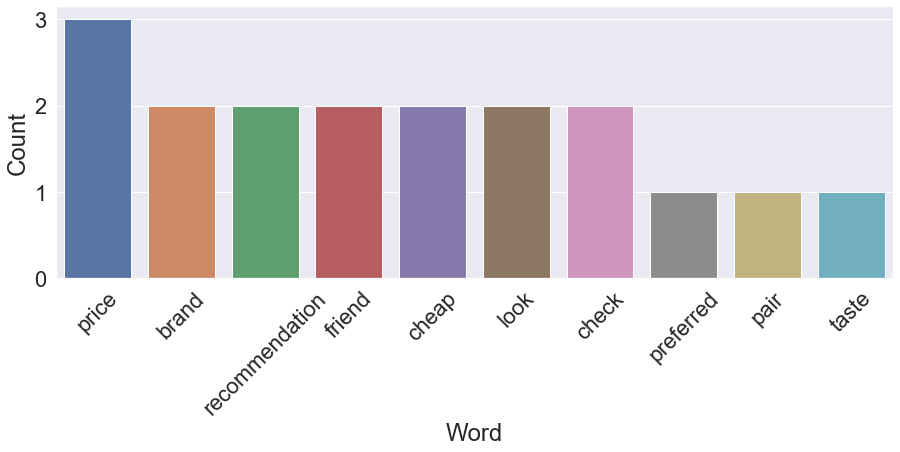

In [91]:
most_freq_words(df['review_lemmas'], 10)

### Build LDA Model

In [53]:
dictionary = corpora.Dictionary(review_lemmas)

In [54]:
doc_term_matrix = [dictionary.doc2bow(review) for review in review_lemmas]

In [83]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

LDA = gensim.models.ldamodel.LdaModel


lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=3, random_state=100, chunksize=1000, passes=50)
# lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=4, random_state=100, chunksize=1000, passes=50)

#### Print the LDA topics

In [84]:
lda_model.print_topics()

[(0,
  '0.097*"recommendation" + 0.097*"friend" + 0.097*"look" + 0.056*"good" + 0.056*"base" + 0.056*"fancy" + 0.056*"packaging" + 0.056*"cheap" + 0.055*"pair" + 0.055*"taste"'),
 (1,
  '0.097*"check" + 0.056*"price" + 0.056*"cheap" + 0.056*"label" + 0.056*"rating" + 0.056*"year" + 0.056*"love" + 0.056*"rise" + 0.055*"bird" + 0.055*"town"'),
 (2,
  '0.068*"price" + 0.068*"brand" + 0.066*"stick" + 0.066*"certain" + 0.066*"origin" + 0.066*"location" + 0.066*"experience" + 0.066*"past" + 0.066*"buy" + 0.066*"review"')]

#### Visualize the topics

In [85]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
display(vis)

C:\Users\dbarker3\myAnaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.060895  0.068735       1        1  36.985607
0     -0.104716  0.007901       2        1  35.602371
2      0.043821 -0.076636       3        1  27.412022, topic_info=   Category      Freq            Term     Total  loglift  logprob
7   Default  1.000000          friend  1.000000  30.0000  30.0000
8   Default  1.000000  recommendation  1.000000  29.0000  29.0000
14  Default  1.000000            look  1.000000  28.0000  28.0000
15  Default  1.000000           check  1.000000  27.0000  27.0000
25  Default  1.000000           stick  1.000000  26.0000  26.0000
..      ...       ...             ...       ...      ...      ...
14   Topic3  0.173359            look  1.686969  -0.9811  -4.0958
7    Topic3  0.173357          friend  1.686968  -0.9811  -4.0958
8    Topic3  0.173357  recommendation  1.686968  -0.9811  -4.0958
9    Topic3  0.173873           cheap  1.707729  -0.9904  -4.0928
15   Topic3  0.173228           check  1.728482  -1.0062  -4.0965

[120 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
6         2  0.891428            base
21        1  0.875300            bird
0         1  0.602659           brand
0         3  0.602659           brand
28        3  0.929566             buy
24        3  0.929709         certain
9         1  0.585573           cheap
9         2  0.585573           cheap
15        1  0.578542           check
4         3  0.929680      experience
13        2  0.891426           fancy
7         2  0.592779          friend
23        2  0.891422            good
16        1  0.875240           label
19        3  0.929705        location
14        2  0.592779            look
10        1  0.875259            love
20        3  0.929705          origin
29        1  0.875411      outlooking
27        2  0.891464       packaging
2         2  0.891481            pair
5         3  0.929680            past
1         1  0.875342       preferred
11        1  0.449361           price
11        2  0.449361           price
11        3  0.449361           price
17        1  0.875240          rating
8         2  0.592779  recommendation
26        3  0.929566          review
12        1  0.875259            rise
25        3  0.929709           stick
3         2  0.891481           taste
22        1  0.875300            town
18        1  0.875240            year, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])